In [1]:
import pandas as pd
import numpy as np
#import GridMet as gm

In [2]:
strt = '1980-01-01'
nd = '2012-12-31'

In [3]:
niwot1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/niwot_snotel.pcl')[strt:nd]
c1_P1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/C1_chart_prec.pcl')[strt:nd]

#c1_P1.head(20)

In [4]:
for i in c1_P1.index:
    
    # skip entries that are only one day
    if (c1_P1.loc[i,'Qual_days'] == 1) or (np.isnan(c1_P1.loc[i,'Qual_days']) == True):
        continue
    else:
        days = c1_P1.loc[i,'Qual_days']
        td = pd.datetools.timedelta(days-1)
        strt2 = i-td
        c1_P1.loc[strt2:i,'P'] = c1_P1.loc[i,'P']/float(days)
        c1_P1.loc[strt2:i,'Qual_days'] = 1.
        c1_P1.loc[strt2:i,'flag'] = 'F'

c1_T1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/C1_chart_temp.pcl')[strt:nd]

## now do D1

d1_P1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/D1_prec.pcl')[strt:nd]

for i in d1_P1.index:
    
    # skip entries that are only one day
    if (d1_P1.loc[i,'Qual_days'] == 1) or (np.isnan(d1_P1.loc[i,'Qual_days']) == True):
        continue
    else:
        days = d1_P1.loc[i,'Qual_days']
        td = pd.datetools.timedelta(days-1)
        strt2 = i-td
        d1_P1.loc[strt2:i,'P'] = d1_P1.loc[i,'P']/float(days)
        d1_P1.loc[strt2:i,'Qual_days'] = 1.
        d1_P1.loc[strt2:i,'flag'] = 'F'

d1_T1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/D1_temp.pcl')[strt:nd]

In [20]:
# Combine all of d1 into a single data frame
d1tmp = pd.DataFrame()
d1tmp['Tmin'] = d1_T1.Tmin
d1tmp['Tmax'] = d1_T1.Tmax
d1tmp['Tave'] = d1_T1.Tave
d1tmp['P'] = d1_P1.P

d1tmp.loc[np.isnan(d1tmp.P),'P'] = 0. # set missing precip values to 0.
d1tmp.interpolate(inplace=True, method='linear') # interpolate the missing temperature values
d1tmp.to_pickle('./d1_combo.df')

In [21]:
# Combine all of c1 into a single data frame
c1tmp = pd.DataFrame()
c1tmp['Tmin'] = c1_T1.Tmin
c1tmp['Tmax'] = c1_T1.Tmax
c1tmp['Tave'] = c1_T1.Tave
c1tmp['P'] = c1_P1.P

c1tmp.loc[np.isnan(c1tmp.P),'P'] = 0. # set missing precip values to 0.
c1tmp.interpolate(inplace=True, method='linear') # interpolate the missing temperature values
c1tmp.to_pickle('./c1_combo.df')

In [5]:
niwot = gm.makeGridMetStation('niwot_snotel',3020.,niwot1.index,niwot1.ATmax,niwot1.ATmin,niwot1.ATave,niwot1.precip)
c1 = gm.makeGridMetStation('c1',3018.,c1_T1.index,c1_T1.Tmax,c1_T1.Tmin,c1_T1.Tave,c1_P1.P)
d1 = gm.makeGridMetStation('d1',3743.,d1_T1.index,d1_T1.Tmax,d1_T1.Tmin,d1_T1.Tave,d1_P1.P)

In [57]:
lapse = gm.makeGridMetLapseRate('como',c1,d1,'d')

/Users/barnhatb/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [7]:
dem_path = '/RHESSys/ComoCreek_new/auxdata/como_gridclim_180m.tiff'
patch_path = '/RHESSys/ComoCreek_new/auxdata/gridmet_map.tiff'
frmt = 'asciiGrid'
out_path = '/RHESSys/ComoCreek_new/clim/'
prfx = 'como_grid'

In [8]:
gm.GridMet(dem_path,patch_path,niwot,lapse,out_path,frmt,prfx)

[****************100%******************]  8401 of 8401 complete Saving asciiGrid files.
Done!


In [14]:
lapse.Tlapse['2012-12']

2012-12-31   -0.013971
Freq: M, Name: Tlapse, dtype: float64

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline

In [33]:
def doy(dt):
    import pandas as pd
    return int(pd.datetime.strftime(dt,'%j'))

In [72]:
lap = pd.DataFrame({'tlapse':lapse.Tavelapse,'plapse':lapse.Plapse,'Tmaxlapse':lapse.Tmaxlapse,'Tminlapse':lapse.Tminlapse},index=lapse.index)

In [73]:
lap['doy'] = lap.index.map(doy)

In [74]:
lap.head()

,Tmaxlapse,Tminlapse,plapse,tlapse,doy
1990-01-01,-0.012414,-0.011034,0.000000,-0.011724,1
1990-01-02,-0.012414,-0.011034,-0.006897,-0.010345,2
1990-01-03,-0.012414,-0.011034,0.001379,-0.009655,3
1990-01-04,-0.012414,-0.011034,0.000000,-0.012414,4
1990-01-05,-0.012414,-0.011034,0.001379,-0.007586,5


In [61]:
lap2 = lap.groupby(by='doy').mean()

In [62]:
s = sp.interpolate.UnivariateSpline(lap2.index,lap2.plapse)
lap2['pspline'] = s(lap2.index)

In [63]:
s = sp.interpolate.UnivariateSpline(lap2.index,lap2.tlapse,k=4)
lap2['tspline'] = s(lap2.index)

0.00215750048473


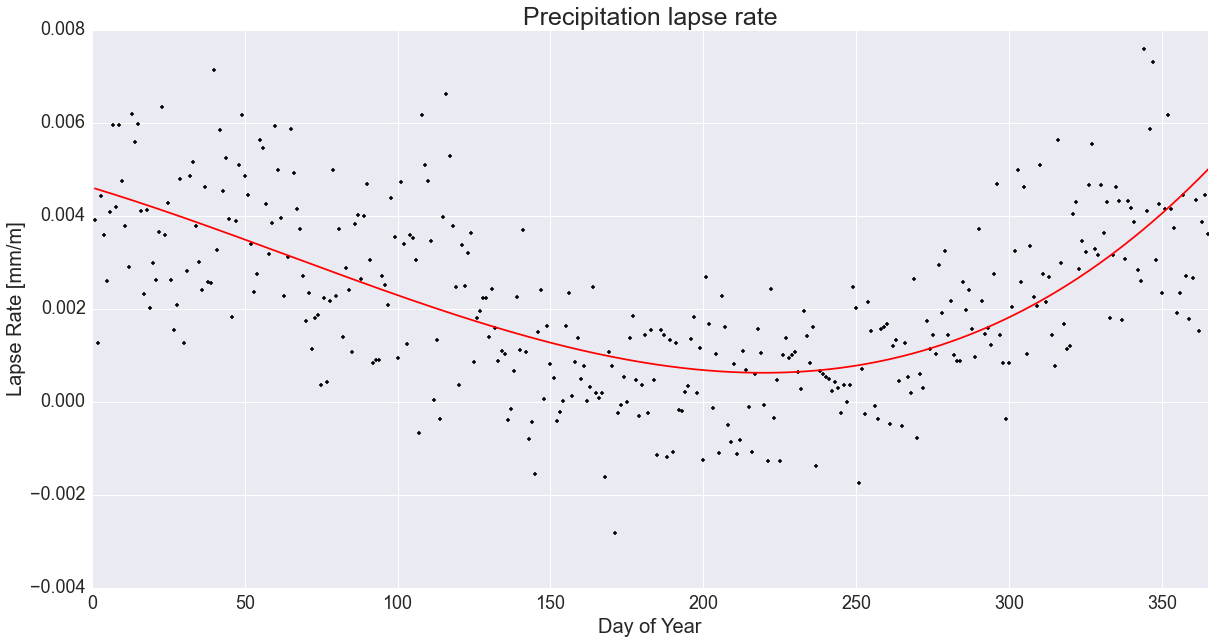

In [69]:
plt.figure(figsize=(20,10))
plt.plot(lap2.index,lap2.plapse,'.k')
plt.plot(lap2.index,lap2.pspline,'-r')
plt.xlim(0,365)
print lap2.pspline.mean()
plt.title('Precipitation lapse rate', fontsize = 25)
plt.xlabel('Day of Year', fontsize = 20)
plt.ylabel('Lapse Rate [mm/m]', fontsize = 20)

ax = plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=18);
plt.setp(ax.get_yticklabels(), fontsize=18);

plt.savefig('./figures/como_p_lapse.png')

In [ ]:
plt.plot(lap.)

-0.00765395990529


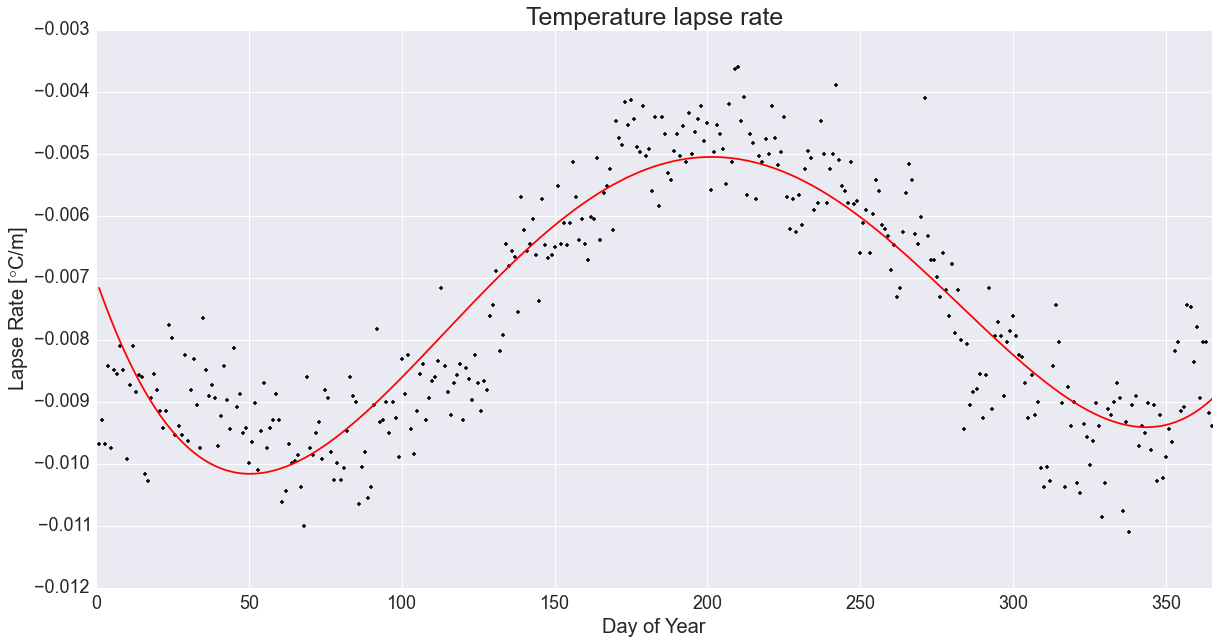

In [70]:
plt.figure(figsize=(20,10))
plt.plot(lap2.index,lap2.tlapse,'.k')
plt.plot(lap2.index,lap2.tspline,'-r')
plt.xlim(0,365)
print lap2.tspline.mean()
plt.title('Temperature lapse rate', fontsize = 25)
plt.xlabel('Day of Year', fontsize = 20)
plt.ylabel('Lapse Rate [$\degree$C/m]', fontsize = 20)
ax = plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=18);
plt.setp(ax.get_yticklabels(), fontsize=18);
plt.savefig('./figures/como_t_lapse.png')

In [75]:
lap.describe()

,Tmaxlapse,Tminlapse,plapse,tlapse,doy
count,8.401000e+03,8.401000e+03,8401.000000,8401.000000,8401.000000
mean,-1.241379e-02,-1.103448e-02,0.002157,-0.007651,183.130699
std,1.625850e-10,2.816055e-10,0.006927,0.004009,105.448069
min,-1.241379e-02,-1.103448e-02,-0.067586,-0.033793,1.000000
25%,-1.241379e-02,-1.103448e-02,0.000000,-0.010345,92.000000
50%,-1.241379e-02,-1.103448e-02,0.000000,-0.007586,183.000000
75%,-1.241379e-02,-1.103448e-02,0.004138,-0.004828,274.000000
max,-1.241379e-02,-1.103448e-02,0.089655,0.014483,366.000000


In [42]:
import numpy as np

In [55]:
print 'Precip. Lapse 95%:',np.percentile(lap.plapse.as_matrix(),95)
print 'Precip. Lapse 05%:',np.percentile(lap.plapse.as_matrix(),5)

Precip. Lapse 95%: 0.00565763546798
Precip. Lapse 05%: -0.00035595105673


In [56]:
print 'Temp. Lapse 95%:',np.percentile(lap.tlapse,95)
print 'Temp. Lapse 05%:',np.percentile(lap.tlapse,5)

Temp. Lapse 95%: -0.00344827586207
Temp. Lapse 05%: -0.0113119941698


In [47]:
lap.describe()

,plapse,tlapse,doy
count,276.000000,276.000000,276.000000
mean,0.002176,-0.007767,197.155797
std,0.001989,0.002451,105.467725
min,-0.002023,-0.014621,31.000000
25%,0.000690,-0.009445,112.750000
50%,0.001696,-0.007858,197.000000
75%,0.003426,-0.006038,281.500000
max,0.008867,-0.001379,366.000000
